In [1]:
# load a text file and iterate over it line by line
avg_loss_valid = {}
avg_loss = {}
with open("logs.txt") as f:
     for line in f:
        if line.startswith("Average Validation Loss"):
            line = line.split("|")
            loss = float(line[0].split(" ")[-2])
            step = int(line[1].split(" ")[-2])
            avg_loss_valid[step] = loss

        elif line.startswith("Average Train Loss"):
            line = line.split("|")
            loss = float(line[0].split(" ")[-2])
            step = int(line[1].split(" ")[-2])
            avg_loss[step] = loss

In [2]:
import scipy.io

def save_as_mat(variable, file_name):
    """
    Save a variable to a .mat file.
    
    Args:
    variable (dict): The variable to save, typically a dictionary.
    file_name (str): The path to the file where the data will be saved.
    """
    scipy.io.savemat(file_name, variable)

# Example usage:
# save_as_mat(avg_loss_valid, 'avg_loss_valid.mat')
# save_as_mat(avg_loss, 'avg_loss.mat')


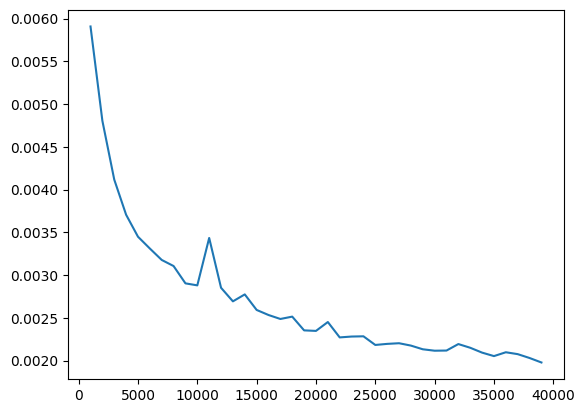

In [3]:
import matplotlib.pyplot as plt
plt.plot(list(avg_loss_valid.keys()), list(avg_loss_valid.values()))
#plt.plot(list(avg_loss.keys()), list(avg_loss.values()))
#plt.yscale("log")

In [4]:
from dataset import Edinb_SE_Dataset, make_loader
import matplotlib.pyplot as plt
from utils.hparams import HParam
from model.coherence_net.model import CoherenceNet
import torch
import numpy as np

def gen_log_space(limit, n):
    result = [1]
    if n>1:  # just a check to avoid ZeroDivisionError
        ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    while len(result)<n:
        next_value = result[-1]*ratio
        if next_value - result[-1] >= 1:
            # safe zone. next_value will be a different integer
            result.append(next_value)
        else:
            # problem! same integer. we need to find next_value by artificially incrementing previous value
            result.append(result[-1]+1)
            # recalculate the ratio so that the remaining values will scale correctly
            ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    # round, re-adjust to 0 indexing (i.e. minus 1) and return np.uint64 array
    return np.array(list(map(lambda x: round(x)-1, result)), dtype=np.int64)

def apply_selection(conv_wt_pt, embedding):
    out_embedding = torch.zeros(embedding.shape)
    weight = conv_wt_pt #torch.load(conv_wt_pt)
    for i in range(0, 512):
        k = weight[:, i:i+1, :, :]
        e = embedding[:, i:i+1, :, :]
        out_embedding[:, i:i+1, :, :] = torch.nn.functional.conv2d(e, k, padding="same")
    return out_embedding

#log_space = gen_log_space(1025, 128)

config = HParam("config-128.yaml")
model = CoherenceNet(config.Coherence_Net_Config.layer1, config.Coherence_Net_Config.layer2)
model = model.lay1.stream2
checkpoint = torch.load(config.SE_Config.lay1_stream2_bestchkpt_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)

<All keys matched successfully>

Dataset Length: 100
loader complete


0it [00:00, ?it/s]

mli_mfe_mse_mlo-m200-ffa_fbe_fti
torch.Size([1, 1, 128, 40]) The shape of the input spec
torch.Size([1, 3]) The shape of the indicator
tensor([[0., 1., 0.]])
['noisy_mli_mfe_mse_mlo-m200-ffa_fbe_fti', 'clean_mli_mfe_mse_mlo-m200-ffa_fbe_fti']


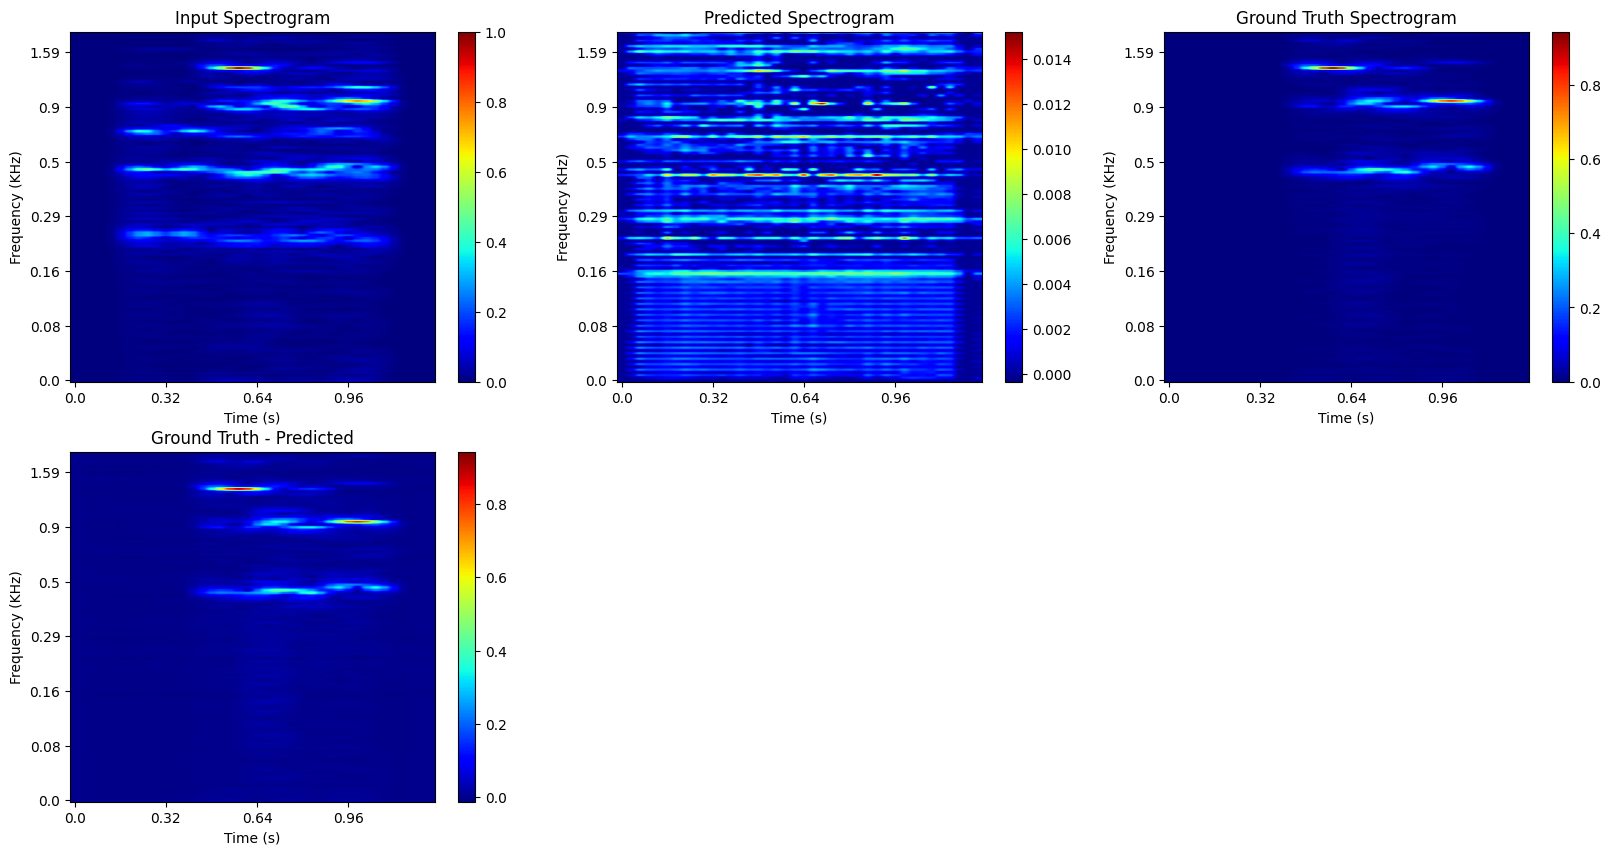

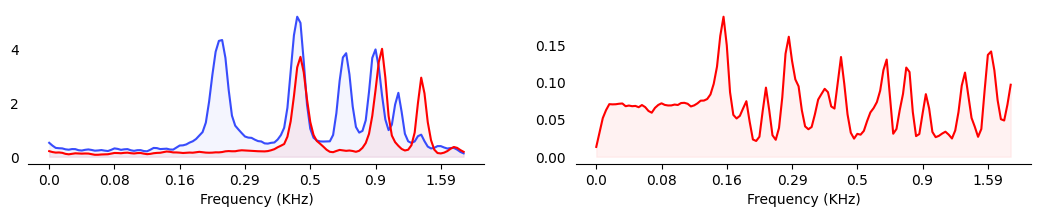

1it [00:02,  2.79s/it]

mlu_mlo_mge_mli-p80-fti_ffa_fbe


1it [00:04,  4.05s/it]


In [6]:
from dataset import gen_log_space
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d

# Adjust these paths and parameters
clean_files_path = "/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/female_alone_random"  #shifted_   sftp://10.160.200.29/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/1_mixture_random/mti_mni_mfa_mne-p80-ffa_fti_fbe.wav
noisy_files_path = "/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/mix_random"   #male_alone_random"  #shifted_
batch_size = 1
model_type = "coherence_net"
save_path = "/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/shifted_male_in_male_attention_random_conv/"
female_attn = True
u = 0

log_space = gen_log_space(500, 128)

model = model.to("cuda")

import numpy as np

# Instantiate the dataset
dataset = Edinb_SE_Dataset(clean_files_path, noisy_files_path, pad = True)
                    
print(f"Dataset Length: {len(dataset)}")

# Instantiate the DataLoader
loader = torch.utils.data.DataLoader(dataset= dataset,
                                            batch_size= 1,
                                            shuffle=False,
                                            collate_fn = dataset.collate_batch_coherence_net,
                                            pin_memory=True,
                                            num_workers=0)

print("loader complete")

# Iterate over the DataLoader
for i, (input_spec, output_spec, indicator, phase_mixed, raw_wavs_target, speaker_ids) in tqdm(enumerate(loader)):
    # For now, just print the shape of the loaded data
    print(speaker_ids[0][6:])

    if female_attn:
        input_spec = input_spec[1:2]
        indicator = indicator[1:2]
    else:
        input_spec = input_spec[0:1]
        indicator = indicator[0:1]

    #input_spec = torch.ones_like(input_spec)

    # ouput from the model
    model_pred, model_pred_before, model_pred_after = model(input_spec.to("cuda"), indicator.to("cuda"))

    model_pred_after = apply_selection(model.conv_final[0].weight, model_pred_after)

    model_pred = model_pred.to("cpu")
    model_pred_before = model_pred_before.to("cpu")
    model_pred_after = model_pred_after.to("cpu")

    #torch.save(model_pred_before, save_path + "before_" + speaker_ids[0][6:] + ".pt")
    #torch.save(model_pred_after, save_path + "after_" + speaker_ids[0][6:] + ".pt")
    
    if u < 1:
        print(input_spec.shape, "The shape of the input spec")
        print(indicator.shape, "The shape of the indicator")
        print(indicator)

        plt.figure(figsize=(20, 10))
        
        print(speaker_ids)

        #time_axis = np.arange(0, 40) * 256/16000
        # Visualizing the spectrogram of the first item in the batch
        plt.subplot(2, 3, 1)
        plt.imshow(input_spec[0, 0].numpy(), aspect='auto', origin='lower', cmap='jet')
        plt.colorbar()
        plt.xticks([i for i in range(0, 40, 10)], [i*(512/16000) for i in range(0, 40, 10)])
        plt.yticks([i for i in range(0, 128, 20)], [round(log_space[i]*(8000/2048)/1000, 2) for i in range(0, 128, 20)])
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (KHz)")
        plt.title("Input Spectrogram")
        
        plt.subplot(2, 3, 2)
        plt.imshow(model_pred[0, 0].detach().numpy(), aspect='auto', origin='lower', cmap='jet')
        plt.colorbar()
        plt.xticks([i for i in range(0, 40, 10)], [i*(512/16000) for i in range(0, 40, 10)])
        plt.yticks([i for i in range(0, 128, 20)], [round(log_space[i]*(8000/2048)/1000, 2) for i in range(0, 128, 20)])
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency KHz)")
        plt.title("Predicted Spectrogram")

        plt.subplot(2, 3, 3)
        plt.imshow(output_spec[1, 0].numpy(), aspect='auto', origin='lower', cmap='jet')
        plt.colorbar()
        plt.xticks([i for i in range(0, 40, 10)], [i*(512/16000) for i in range(0, 40, 10)])
        plt.yticks([i for i in range(0, 128, 20)], [round(log_space[i]*(8000/2048)/1000, 2) for i in range(0, 128, 20)])
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (KHz)")
        plt.title("Ground Truth Spectrogram")

        plt.subplot(2, 3, 4)
        plt.imshow(output_spec[1, 0].numpy() - model_pred[0, 0].detach().numpy(), aspect='auto', origin='lower', cmap='jet')
        plt.colorbar()
        plt.xticks([i for i in range(0, 40, 10)], [i*(512/16000) for i in range(0, 40, 10)])
        plt.yticks([i for i in range(0, 128, 20)], [round(log_space[i]*(8000/2048)/1000, 2) for i in range(0, 128, 20)])
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (KHz)")
        plt.title("Ground Truth - Predicted")

        #plt.savefig(save_path + "spectrogram_" + speaker_ids[0][6:] + ".png", dpi =300)

        male = output_spec[0, 0].numpy().sum(axis=1)
        female = output_spec[1, 0].numpy().sum(axis=1)

        predicted = model_pred[0, 0].detach().numpy().sum(axis=1)

        plt.figure(figsize=(20, 2))
        plt.subplot(1, 3, 1)

        # Applying Gaussian filter for smoothing
        sigma = 1

        smoothed_male = gaussian_filter1d(male, sigma)
        smoothed_female = gaussian_filter1d(female, sigma)

        # Plotting the smoothed data
        plt.plot(smoothed_male, color='#384CFC', label='Male')
        plt.plot(smoothed_female, color='#FF0000', label='Female')
        plt.xticks([i for i in range(0, 128, 20)], [round(log_space[i]*(8000/2048)/1000, 2) for i in range(0, 128, 20)])
        plt.xlabel("Frequency (KHz)")

        # Shading the area below the smoothed lines
        plt.fill_between(range(len(smoothed_male)), smoothed_male, color='#384CFC', alpha=0.05)
        plt.fill_between(range(len(smoothed_female)), smoothed_female, color='#FF0000', alpha=0.05)

        # Removing the top, right, and left borders
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)

        # Only keeping the x-axis
        plt.gca().spines['bottom'].set_color('black')
        plt.gca().tick_params(axis='y', which='both', left=False)  # Remove y-axis ticks

        plt.subplot(1, 3, 2)

        # Applying Gaussian filter for smoothing to predicted data
        smoothed_predicted = gaussian_filter1d(predicted, sigma)

        # Plotting the smoothed data
        if female_attn == False:
            plt.plot(smoothed_predicted, color='#384CFC', label='Predicted')
            plt.xticks([i for i in range(0, 128, 20)], [round(log_space[i]*(8000/2048)/1000, 2) for i in range(0, 128, 20)])
            plt.xlabel("Frequency (KHz)")

            # Shading the area below the smoothed lines
            plt.fill_between(range(len(smoothed_predicted)), smoothed_predicted, color='#384CFC', alpha=0.05)
        
        elif female_attn == True:
            plt.plot(smoothed_predicted, color='#FF0000', label='Predicted')
            plt.xticks([i for i in range(0, 128, 20)], [round(log_space[i]*(8000/2048)/1000, 2) for i in range(0, 128, 20)])
            plt.xlabel("Frequency (KHz)")

            # Shading the area below the smoothed lines
            plt.fill_between(range(len(smoothed_predicted)), smoothed_predicted, color='#FF0000', alpha=0.05)

        # Removing the top, right, and left borders
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)

        # Only keeping the x-axis
        plt.gca().spines['bottom'].set_color('black')
        plt.gca().tick_params(axis='y', which='both', left=False)  # Remove y-axis ticks

        plt.show()

    if u == 1:
        break
    u += 1
        

In [10]:
freqs = [round(log_space[i]*(8000/2048), 2) for i in range(0, 128, 1)]
save_as_mat({"frequencies": freqs}, "frequencies.mat")


In [6]:

#save_as_mat({"male_spectrum": output_spec[0, 0].numpy(),
#            "female_spectrum": output_spec[1, 0].numpy()},
#            "data_spectrograms/shifted_mixture_input.mat")

save_as_mat({"male_attention": model_pred[0, 0].detach().numpy()},
            "data_spectrograms/shifted_mixture_input_selection_male_attn_prediction.mat")

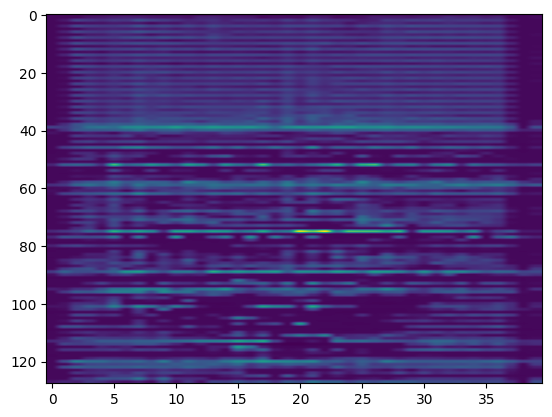

In [10]:
plt.imshow(model_pred[0, 0].detach().numpy(), aspect="auto")

In [7]:
model_pred[0, 0].detach().numpy().shape

(128, 40)

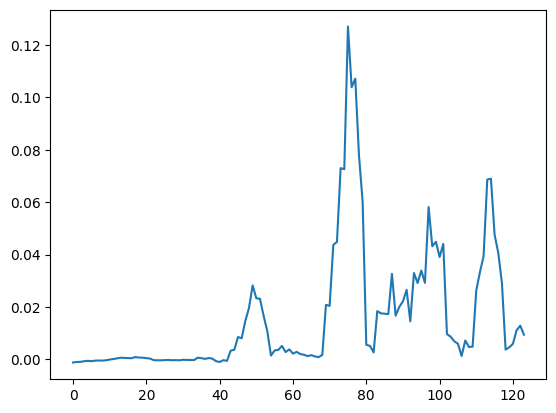

In [12]:
import numpy as np

def moving_average_smoothing(data, window_size):
    """
    Apply moving average smoothing to a numpy array.
    
    Args:
    data (np.array): Input data array to smooth.
    window_size (int): The size of the moving window.
    
    Returns:
    np.array: Smoothed data.
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")
    if window_size > len(data):
        raise ValueError("Window size must not be greater than the length of the data.")
    
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    smoothed_data = (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size
    
    return smoothed_data


plt.plot(moving_average_smoothing(predicted, 5))


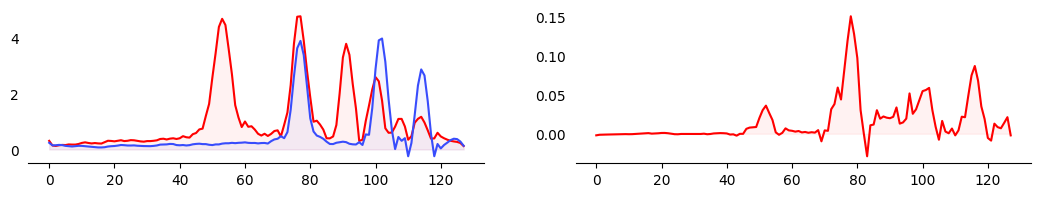

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

plt.figure(figsize=(20, 2))
plt.subplot(1, 3, 1)

# Applying Savitzky-Golay filter for smoothing
# Window size and polynomial order need to be odd numbers
window_size = 11 # This should be less than the number of data points and odd
poly_order = 5    # Degree of the polynomial fit

smoothed_male = savgol_filter(male, window_size, poly_order)
smoothed_female = savgol_filter(female, window_size, poly_order)

# Plotting the smoothed data
plt.plot(smoothed_male, color='#FF0000', label='Male')
plt.plot(smoothed_female, color='#384CFC', label='Female')

# Shading the area below the smoothed lines
plt.fill_between(range(len(smoothed_male)), smoothed_male, color='#FF0000', alpha=0.05)
plt.fill_between(range(len(smoothed_female)), smoothed_female, color='#384CFC', alpha=0.05)

# Removing the top, right, and left borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Only keeping the x-axis
plt.gca().spines['bottom'].set_color('black')
plt.gca().tick_params(axis='y', which='both', left=False)  # Remove y-axis ticks

plt.subplot(1, 3, 2)

# Applying Savitzky-Golay filter for smoothing
# Window size and polynomial order need to be odd numbers
window_size = 11 # This should be less than the number of data points and odd
poly_order = 5    # Degree of the polynomial fit

smoothed_predicted = savgol_filter(predicted, window_size, poly_order)

# Plotting the smoothed data
plt.plot(smoothed_predicted, color='#FF0000', label='Male')

# Shading the area below the smoothed lines
plt.fill_between(range(len(smoothed_predicted)), smoothed_predicted, color='#FF0000', alpha=0.05)

# Removing the top, right, and left borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Only keeping the x-axis
plt.gca().spines['bottom'].set_color('black')
plt.gca().tick_params(axis='y', which='both', left=False)  # Remove y-axis ticks

plt.show()


In [14]:
import os
import random

def pick_random_wavs(folder_path, num_files=100):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.wav')]
    selected_files = random.sample(all_files, num_files)
    return selected_files

# Example usage
folder_path = "/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/male_alone/"
picked_files = pick_random_wavs(folder_path)

import IPython.display as ipd

# Play the first picked file
ipd.Audio(picked_files[0])

folder_path = "/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/female_alone/"
picked_files = pick_random_wavs(folder_path)

# Play the first picked file
ipd.Audio(picked_files[0])


FileNotFoundError: [Errno 2] No such file or directory: '/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/male_alone/'

In [ ]:
import soundfile as sf
import numpy as np
import os

def sum_audio_files(file_path1, file_path2, output_folder):
    """
    Loads two audio files, sums their audio signals, and saves the resulting audio file.

    Args:
    file_path1 (str): Path to the first audio file.
    file_path2 (str): Path to the second audio file.
    output_folder (str): Folder where the summed audio file will be saved.

    Returns:
    str: Path to the saved audio file.
    """
    # Load audio files
    data1, samplerate1 = sf.read(file_path1)
    data2, samplerate2 = sf.read(file_path2)

    name = file_path1.split("/")[-1].split(".")[0]

    # Check if both files have the same sample rate
    if samplerate1 != samplerate2:
        raise ValueError("Audio files must have the same sample rate")

    # Pad the shorter file if the lengths are different
    min_len = min(len(data1), len(data2))
    if len(data1) > min_len:
        data1 = data1[:min_len]
    if len(data2) > min_len:
        data2 = data2[:min_len]

    # Sum the audio signals
    summed_data = data1 + data2

    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Construct output file path
    output_file_path = os.path.join(output_folder, f"{name}.wav")

    # Save the summed audio file
    sf.write(output_file_path, summed_data, samplerate1)

    return output_file_path

# Example usage:
# output_path = sum_audio_files("path/to/audio1.wav", "path/to/audio2.wav", "path/to/output_folder")
# print("Summed audio saved to:", output_path)
sum_audio_files("/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/shifted_male_alone_random/mti_mni_mfa_mne-p80-ffa_fti_fbe.wav", "/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/shifted_female_alone_random/mti_mni_mfa_mne-p80-ffa_fti_fbe.wav", 
"/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/1_shifted_mixture_alone_random")


In [ ]:
def find_positions(matrix):
    ones_positions = []
    minus_ones_positions = []
    
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            if matrix[i][j] == 1:
                ones_positions.append((i, j))
            elif matrix[i][j] == -1:
                minus_ones_positions.append((i, j))
    
    return minus_ones_positions, ones_positions

# Example usage:
matrix = [
    [1, -1, 0],
    [0, 1, -1],
    [-1, 0, 1]
]

minus_ones, ones = find_positions(matrix)
print("Positions of -1s:", minus_ones)
print("Positions of 1s:", ones)
